Demonstration of my MLP architecture from scratch

In [191]:
import sys
import os
sys.path.append(os.path.abspath(".."))
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


#Optimizers
from src.optimizers.base import Optimizer
from src.optimizers.sgd import SGD
from src.optimizers.sgdm import SGD_momentum
from src.optimizers.rmsprop import RMSprop
from src.optimizers.adam import ADAM

#Layers
from src.layers.linear import Linear
from src.layers.activation import ReLU, Tanh, Sigmoid, Leaky_ReLU, ELU
from src.layers.dropout import Dropout

#Model
from src.models.mlp import MLP

#Trainer
from src.training.train_mlp import Trainer


In [12]:
LoadObject = np.load("../dataset/mnist70.npz")
linearPictureLength = 28
X = LoadObject['X']
y = LoadObject['y']
del LoadObject
#Load the MNIST Dataset

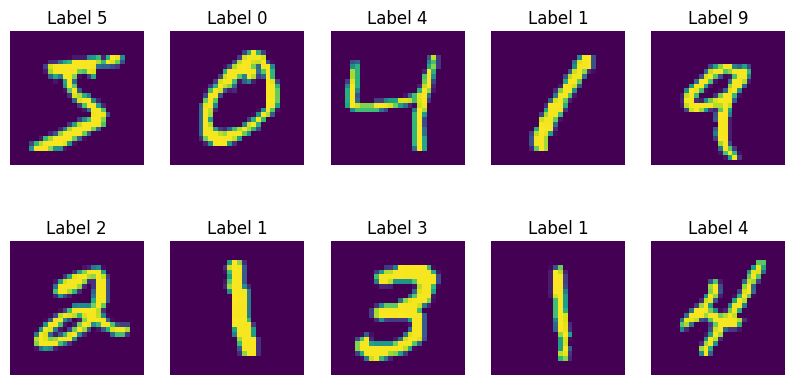

In [13]:
#Sample of the dataset
fig, axes = plt.subplots(2, 5, figsize=(10, 5)) 
axes = axes.ravel()

for i in range(10):
    axes[i].imshow(X[i].reshape(28, 28))
    axes[i].set_title(f"Label {y[i]}")
    axes[i].axis("off")
plt.show()

In [15]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0) #Validation and test set

In [17]:
#One-Hot encoding of the data
y_train_encoded = np.zeros((y_train.shape[0],10))
for i in range(y_train.shape[0]):
    y_train_encoded[i,y_train[i]] = 1

y_val_encoded = np.zeros((y_val.shape[0],10))
for i in range(y_val.shape[0]):
    y_val_encoded[i,y_val[i]] = 1

In [18]:
input_size = X_train.shape[1]
output_size = y_train_encoded.shape[1]

In [20]:
def first_MLP():
    model = MLP()
    model.add_layer(Linear(input_size, 256))
    model.add_layer(ReLU())
    model.add_layer(Linear(256,128))
    model.add_layer(ReLU())
    model.add_layer(Linear(128, 64))
    model.add_layer(ReLU())
    model.add_layer(Linear(64,10))

    return model


In [143]:

first_model = first_MLP()
param = first_model.parameters()
for i in range(0,len(param),2):
    print("Shape of the weight data:",param[i].data.shape,"\t Weight grad before training:", param[i].grad)


Shape of the weight data: (784, 256) 	 Weight grad before training: None
Shape of the weight data: (256, 128) 	 Weight grad before training: None
Shape of the weight data: (128, 64) 	 Weight grad before training: None
Shape of the weight data: (64, 10) 	 Weight grad before training: None


In [144]:
optimizer = SGD_momentum(param, lr = 0.05, beta1=0.9)
first_train = Trainer(first_model, optimizer, grad_tracking=False)

In [145]:
first_metrics = first_train.train(X_train, y_train_encoded,X_val,y_val_encoded, epochs = 40,patience =100) 

Epoch 0, Train Loss: 2.4016465525156323, Train Accuracy:0.12701785714285715
Validation Loss: 2.3973047617503647, Validation Accuracy:0.12785714285714286
Epoch 10, Train Loss: 0.039010595049043965, Train Accuracy:0.9893571428571428
Validation Loss: 0.09060479524765389, Validation Accuracy:0.9714285714285714
Epoch 20, Train Loss: 0.007119515738148795, Train Accuracy:0.9992321428571429
Validation Loss: 0.08062743211412832, Validation Accuracy:0.978
Epoch 30, Train Loss: 0.002186709949462486, Train Accuracy:0.9999821428571428
Validation Loss: 0.0872112284582577, Validation Accuracy:0.9781428571428571
Training completed in 48.73s


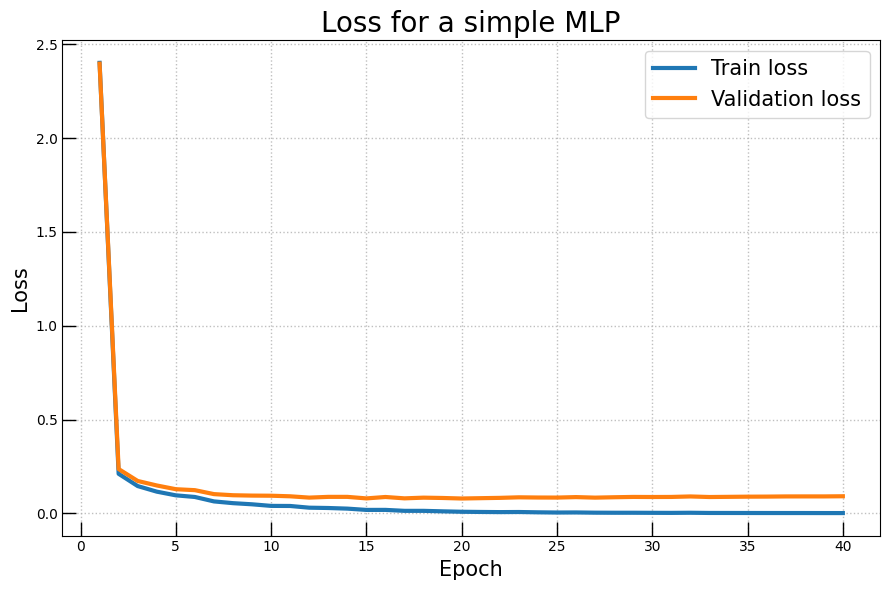

In [146]:
fig, ax = plt.subplots(figsize=(9, 6))
loss=first_metrics["train_loss"]
val_loss=first_metrics["val_loss"]
plt.plot(range(1, len(loss) + 1),loss, linewidth=3, label = "Train loss")
plt.plot(range(1, len(val_loss) + 1),val_loss, linewidth=3, label = "Validation loss")
plt.legend(fontsize = 15)
plt.xlabel("Epoch",size = 15)
plt.ylabel("Loss",size=15)
plt.tick_params(which='major', width=1, length=10, labelsize=10, direction='in', top=False, right=False)
plt.tick_params(which='minor', width=1.0, length=3, direction='in', top=False, right=False)
plt.grid(True, linestyle=':', linewidth=1, alpha=0.8)
plt.title("Loss for a simple MLP", size = 20)
plt.tight_layout()

plt.show()

The plot above shows the model is effectively learning. However, such model can overfit fast, as shown in the validation loss, that's why I implemented: 

-Dropout Layers: Prevents overfitting by reducing the correlation between neurons

-Early stopping: Prevents overfitting by tracking the validation loss

**DROPOUT:**

In [147]:
def Better_model():
    model = MLP()
    model.add_layer(Linear(input_size, 256))
    model.add_layer(ReLU())
    model.add_layer(Linear(256,128))
    model.add_layer(Dropout(rate = 0.3)) #rate is the rate at which neurons are dropped (according to a bernoulli law)
    model.add_layer(ReLU())
    model.add_layer(Linear(128, 64))
    model.add_layer(Dropout(rate = 0.3))
    model.add_layer(ReLU())
    model.add_layer(Linear(64,10))

    return model

In [151]:
dropout = Better_model()

In [152]:
param2=dropout.parameters()
optimizer=SGD_momentum(param2, lr = 0.05, beta1=0.9) #Same configuration as before
train_dropout = Trainer(dropout, optimizer, grad_tracking=True)

In [153]:
metrics = train_dropout.train(X_train, y_train_encoded,X_val,y_val_encoded, epochs = 40,patience=100)

Epoch 0, Train Loss: 2.349325823805294, Train Accuracy:0.10025
Validation Loss: 2.3480506678502717, Validation Accuracy:0.098
Epoch 10, Train Loss: 0.11536041427984843, Train Accuracy:0.9681607142857143
Validation Loss: 0.15195717960222793, Validation Accuracy:0.955
Epoch 20, Train Loss: 0.057689559015966216, Train Accuracy:0.9831964285714285
Validation Loss: 0.11267782706734998, Validation Accuracy:0.9661428571428572
Epoch 30, Train Loss: 0.0345430481583735, Train Accuracy:0.9899285714285714
Validation Loss: 0.10151609167705936, Validation Accuracy:0.9718571428571429
Training completed in 61.78s


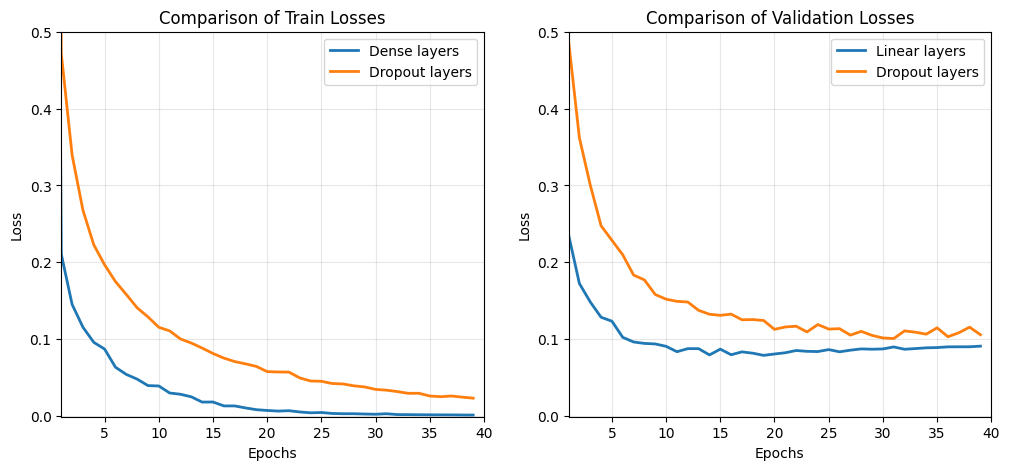

In [190]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Train Loss
ax1.plot(first_metrics["train_loss"], label="Dense layers", linewidth=2)
ax1.plot(metrics["train_loss"], label="Dropout layers", linewidth=2)
ax1.set_title("Comparison of Train Losses")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.set_xlim(1,40)
ax1.set_ylim(-0.001,0.5)
ax1.grid(True, alpha=0.3)

# Validation Loss
ax2.plot(first_metrics["val_loss"], label="Linear layers", linewidth=2) 
ax2.plot(metrics["val_loss"], label="Dropout layers", linewidth=2)
ax2.set_title("Comparison of Validation Losses")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.set_xlim(1,40)
ax2.set_ylim(-0.001,0.5)
ax2.legend(loc="best")
ax2.grid(True, alpha=0.3)


plt.show()

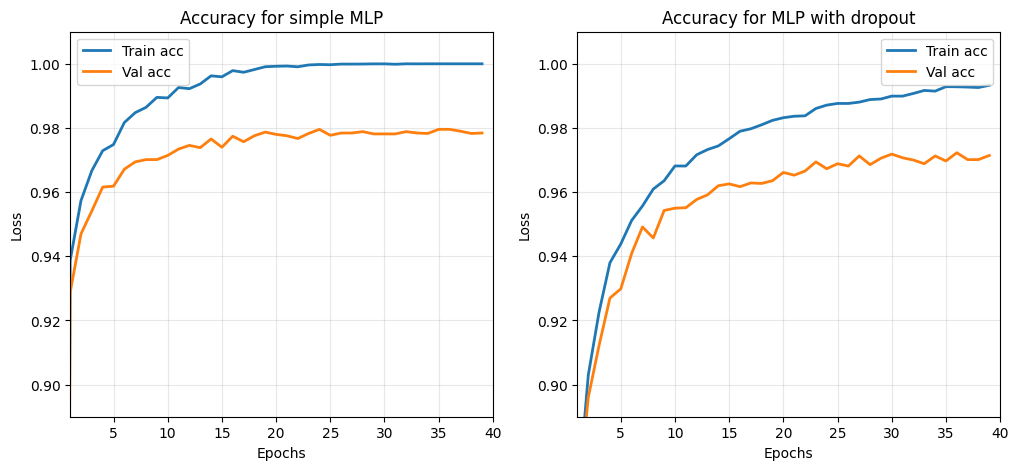

In [177]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Train Loss
ax1.plot(first_metrics["train_acc"], label="Train acc", linewidth=2)
ax1.plot(first_metrics["val_acc"], label="Val acc", linewidth=2)
ax1.set_title("Accuracy for simple MLP")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_xlim(1,40)
ax1.set_ylim(0.89,1.01)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Validation Loss
ax2.plot(metrics["train_acc"], label="Train acc", linewidth=2) 
ax2.plot(metrics["val_acc"], label="Val acc", linewidth=2)
ax2.set_title("Accuracy for MLP with dropout")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.set_xlim(1,40)
ax2.set_ylim(0.89,1.01)
ax2.legend(loc="best")
ax2.grid(True, alpha=0.3)

The Dropout network takes longer to train but generalizes better (less overfitting)

**EARLY STOPPING:**

In [181]:
es_mlp = first_MLP()
param=es_mlp.parameters()
optimizer = SGD_momentum(param, lr = 0.05, beta1=0.9)
train_stop = Trainer(es_mlp, optimizer, grad_tracking=False)

In [182]:
metrics_es = train_stop.train(X_train, y_train_encoded,X_val,y_val_encoded, epochs = 40,patience=5)

Epoch 0, Train Loss: 2.293143332382155, Train Accuracy:0.12619642857142857
Validation Loss: 2.2976787674889265, Validation Accuracy:0.12585714285714286
Epoch 10, Train Loss: 0.038322702077910546, Train Accuracy:0.9897857142857143
Validation Loss: 0.08605723246308165, Validation Accuracy:0.9725714285714285
Epoch 20, Train Loss: 0.008946106204869034, Train Accuracy:0.9986785714285714
Validation Loss: 0.08106447812658346, Validation Accuracy:0.9768571428571429
Early stopping triggered after 25 epochs
Best validation loss: 0.0787 at epoch 19
Training completed in 31.02s
